In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # used for resizing attention maps
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
import torchvision
from torchvision import transforms, datasets, models
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Mar 11 18:12:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from google.colab import drive
drive.mount('/content/drive')

Using device: cuda
Mounted at /content/drive


In [ ]:
import torchvision.models as models

class MILImageFolder(Dataset):
    def __init__(self, root, transform, bag_size=10):

        self.dataset = datasets.ImageFolder(root=root, transform=transform)
        self.bag_size = bag_size

        self.label_to_indices = {}
        for idx, (_, label) in enumerate(self.dataset.samples):
            self.label_to_indices.setdefault(label, []).append(idx)

        self.bags = []
        for label, indices in self.label_to_indices.items():
            np.random.shuffle(indices)
            for i in range(0, len(indices) - bag_size + 1, bag_size):
                bag_indices = indices[i:i + bag_size]
                self.bags.append((bag_indices, label))
        np.random.shuffle(self.bags)

        self.targets = np.array([label for (_, label) in self.bags])

    def __len__(self):
        return len(self.bags)

    def __getitem__(self, index):
        bag_indices, bag_label = self.bags[index]
        bag_images = [self.dataset[i][0] for i in bag_indices]
        bag_tensor = torch.stack(bag_images)
        return bag_tensor, bag_label


#model
class Attention(nn.Module):
    def __init__(self, num_classes=3):
        super(Attention, self).__init__()
        self.L = 512  # Size of the fully-connected layer
        self.D = 128  # Attention layer size
        self.K = 1    # Number of attention heads

        resnet = models.resnet18(pretrained=True)
        # Remove the last fully connected layer
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((30, 30))


        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(512 * 30 * 30, self.L),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.L, self.L),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Linear(self.L * self.K, num_classes)

    def forward(self, x):

        B, bag_size, C, H, W = x.shape
        x = x.view(B * bag_size, C, H, W)
        features = self.feature_extractor(x)
        features = self.pool(features)
        features = features.view(B * bag_size, -1)
        H_features = self.feature_extractor_part2(features)
        H_features = H_features.view(B, bag_size, -1)

        A = self.attention(H_features.view(B * bag_size, -1))
        A = A.view(B, bag_size, self.K).transpose(1, 2)
        A = F.softmax(A, dim=2)

        M = torch.bmm(A, H_features)  # (B, K, L)
        M = M.view(B, -1)  # (B, K*L)
        logits = self.classifier(M)
        probs = torch.softmax(logits, dim=1)
        return logits, probs, A

    def calculate_classification_error(self, X, Y):
        logits, _, _ = self.forward(X)
        preds = torch.argmax(logits, dim=1)
        error = 1.0 - preds.eq(Y).cpu().float().mean().item()
        return error, preds

    def calculate_objective(self, X, Y):
        logits, _, A = self.forward(X)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, Y)
        return loss, A


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Dataset directories
train_augmented_dir = '/content/drive/MyDrive/GBCUD/dataset/train'
output_test_folder = '/content/drive/MyDrive/GBCUD/dataset/test'


train_dataset = MILImageFolder(root=train_augmented_dir, transform=train_transforms, bag_size=10)
test_dataset = MILImageFolder(root=output_test_folder, transform=test_transforms, bag_size=10)

# stratified train/validation split on bag labels
targets = train_dataset.targets
train_idx, val_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

# weighted sampler for the training subset
train_targets = targets[train_idx]
class_counts = np.bincount(train_targets)
sample_weights = np.array([1.0 / class_counts[label] for label in train_targets])
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

In [ ]:

# Hyperparameters
best_dropout = 0.5
best_lr = 1e-5
# each sample is a bag
best_batch_size = 1

final_model = Attention(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.8, 0.6, 3.0], device=device))
optimizer = optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=1e-5)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=best_batch_size, sampler=sampler)
val_loader = DataLoader(val_subset, batch_size=best_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

patience = 10
best_val_loss = np.inf
patience_counter = 0
best_model_wts = None
epochs = 50

for epoch in range(epochs):
    final_model.train()
    running_loss = 0.0
    for bags, labels in train_loader:
        # bags: shape (B, bag_size, 3, 224, 224), labels: shape (B,)
        bags = bags.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits, _, _ = final_model(bags)  # logits shape: (B, num_classes)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        # Multiply by bag_size since one bag contains multiple images.
        running_loss += loss.item() * bags.size(0)
    epoch_loss = running_loss / len(train_subset)
    print(f"Epoch Loss: {epoch_loss:.4f}")

    # Validation pass
    final_model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val_samples = 0
    with torch.no_grad():
        for bags, labels in val_loader:
            bags = bags.to(device)
            labels = labels.to(device)
            logits, _, _ = final_model(bags)
            loss = criterion(logits, labels)
            val_loss += loss.item() * bags.size(0)
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            total_val_samples += labels.size(0)
    val_loss /= total_val_samples
    val_accuracy = val_correct / total_val_samples

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {epoch_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = final_model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model weights after training.
final_model.load_state_dict(best_model_wts)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch Loss: 1.5109
Epoch 1/50, Train Loss: 1.5109, Val Loss: 1.0896, Val Accuracy: 0.3913
Epoch Loss: 1.4200
Epoch 2/50, Train Loss: 1.4200, Val Loss: 1.2026, Val Accuracy: 0.2174
Epoch Loss: 1.3798
Epoch 3/50, Train Loss: 1.3798, Val Loss: 1.1427, Val Accuracy: 0.4348
Epoch Loss: 1.3430
Epoch 4/50, Train Loss: 1.3430, Val Loss: 0.9223, Val Accuracy: 0.3913
Epoch Loss: 1.0351
Epoch 5/50, Train Loss: 1.0351, Val Loss: 0.8341, Val Accuracy: 0.6957
Epoch Loss: 0.9908
Epoch 6/50, Train Loss: 0.9908, Val Loss: 0.7780, Val Accuracy: 0.5652
Epoch Loss: 0.8102
Epoch 7/50, Train Loss: 0.8102, Val Loss: 0.8206, Val Accuracy: 0.5217
Epoch Loss: 0.6859
Epoch 8/50, Train Loss: 0.6859, Val Loss: 0.5539, Val Accuracy: 0.8261
Epoch Loss: 0.6778
Epoch 9/50, Train Loss: 0.6778, Val Loss: 1.0596, Val Accuracy: 0.5652
Epoch Loss: 0.6678
Epoch 10/50, Train Loss: 0.6678, Val Loss: 0.6182, Val Accuracy: 0.5652
Epoch Loss: 0.6555
Epoch 11/50, Train Loss: 0.6555, Val Loss: 0.5100, Val Accuracy: 0.8696
Epoch Lo

<All keys matched successfully>


Evaluation Metrics:
Final Test Accuracy (Attention MIL): 0.7273
Precision: 0.7778
Recall: 0.7222
F1 Score: 0.7238
Confusion Matrix:
[[2 1 0]
 [0 2 2]
 [0 0 4]]


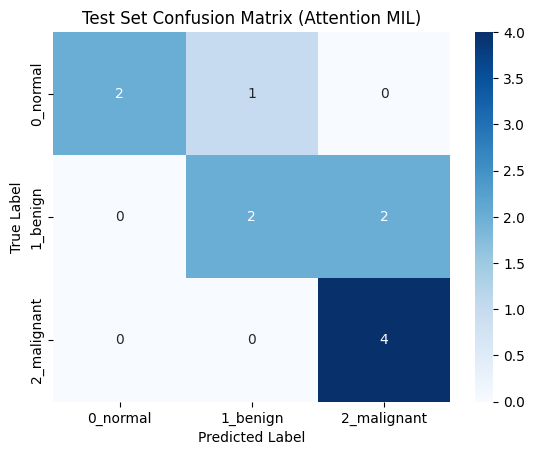

In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve,
                             auc, precision_recall_curve)
# Evaluation
final_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for bags, labels in test_loader:
        bags = bags.to(device)
        logits, _, _ = final_model(bags)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
cmatrix = confusion_matrix(all_labels, all_preds)

print(f"\nEvaluation Metrics:")
print(f"Final Test Accuracy (Attention MIL): {accuracy:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cmatrix)

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=test_dataset.dataset.classes, yticklabels=test_dataset.dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Set Confusion Matrix (Attention MIL)')
plt.show()


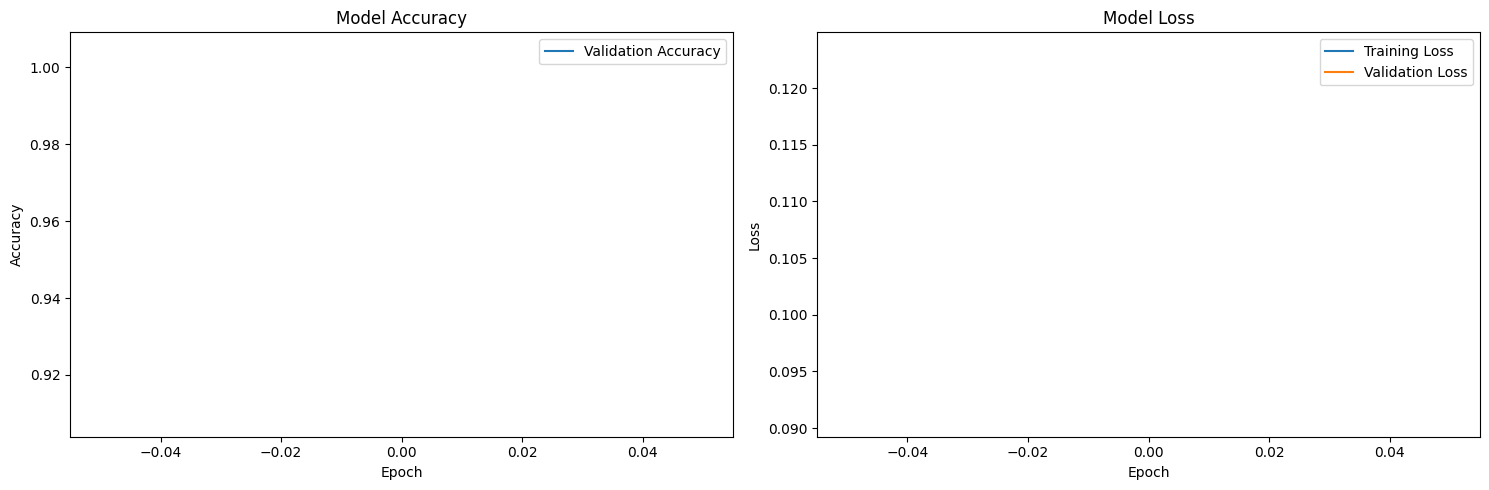

In [ ]:
def plot_training_history(train_losses, val_losses, val_acc):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Accuracy plot
    # ax1.plot(train_acc, label='Training Accuracy')
    ax1.plot(val_acc, label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    # Loss plot
    ax2.plot(train_losses, label='Training Loss')
    ax2.plot(val_losses, label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.tight_layout()
    plt.show()


# Plot training history and confusion matrix
plot_training_history(epoch_loss, val_loss, val_accuracy)

In [ ]:
save_path = '/content/drive/MyDrive/GBCUD/MILprototype2.pth'
torch.save(final_model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/GBCUD/MILprototype2.pth
